In [ ]:
import os
import scipy
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow as tf
import os
from shutil import copyfile
from sklearn.model_selection import train_test_split

# Assuming your data is organized in folders where each folder represents a different class
data_dir = 'C:/Users/tbrag/OneDrive/Desktop/BDA 696 Project/Multi Conditions database'  # Replace this with the path to your dataset

# Get the list of class labels (subfolders)
class_labels = os.listdir(data_dir)

# Create empty lists to store file paths and corresponding labels
file_paths = []
labels = []

# Iterate through each class label folder
for label in class_labels:
    class_path = os.path.join(data_dir, label)

    # Get the list of file names in the current class folder
    files = os.listdir(class_path)

    # Create file paths and corresponding labels
    file_paths.extend([os.path.join(class_path, file) for file in files])
    labels.extend([label] * len(files))

# Split the data into training and testing sets
test_size = 0.2
random_state = 42
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=test_size, random_state=random_state
)

# Create folders for training and testing sets
train_data_folder = "C:/Users/tbrag/OneDrive/Desktop/BDA 696 Project/Multi Conditions database/Train"
test_data_folder = "C:/Users/tbrag/OneDrive/Desktop/BDA 696 Project/Multi Conditions database/Test"

for label in class_labels:
    os.makedirs(os.path.join(test_data_folder, label), exist_ok=True)

# Copy images to the training set folders
for path, label in zip(train_paths, train_labels):
    destination_folder = os.path.join(train_data_folder, label)
    os.makedirs(destination_folder, exist_ok=True)
    destination = os.path.join(destination_folder, os.path.basename(path))
    copyfile(path, destination)

# Copy images to the testing set folders
for path, label in zip(test_paths, test_labels):
    destination_folder = os.path.join(test_data_folder, label)
    os.makedirs(destination_folder, exist_ok=True)
    destination = os.path.join(destination_folder, os.path.basename(path))
    copyfile(path, destination)

# Print the number of samples in the training and testing sets
print(f"Number of samples in the training set: {len(train_paths)}")
print(f"Number of samples in the testing set: {len(test_paths)}")

# Define parameters
batch_size = 32
img_size = (128, 128)
epochs = 500

# Create an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% training, 20% validation
)
# Add Keras layers for additional data augmentation
data_augmentation = keras.Sequential([
    preprocessing.Rescaling(1./255),
    preprocessing.RandomContrast(factor=0.2),
    preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
    preprocessing.Rescaling(255),  # Rescale back to the original range before GaussianNoise
    tf.keras.layers.GaussianNoise(stddev=0.01),
    preprocessing.Rescaling(1./255),  # Final rescaling before feeding to the model
    preprocessing.RandomRotation(factor=0.1)  # Slight rotation
])

# Load and augment the training data
train_generator = datagen.flow_from_directory(
    train_data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load and augment the validation data
validation_generator = datagen.flow_from_directory(
    train_data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Count the number of classes
num_classes = len(train_generator.class_indices)
print(num_classes)

# Build the CNN model
model = keras.Sequential([
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3), padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3), padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Early Stopping That Montitors Validation Loss
es= EarlyStopping(monitor='val_loss',
                  mode='min',
                  patience =10,
                  restore_best_weights=True)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Define randombrightness for augmented model
def random_brightness(image):
    # Apply random brightness augmentation
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image
# Build the model with data augmentation
augmented_model = keras.Sequential([
    data_augmentation,
    layers.Lambda(random_brightness),
    model
])

# Compile the augmented model
augmented_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = augmented_model.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=validation_generator,
    callbacks=[es]
)

# Save the model
augmented_model.save('your_model.h5')

# Load and evaluate the model on a test dataset
test_data_folder = "C:/Users/tbrag/OneDrive/Desktop/BDA 696 Project/Multi Conditions database/Test"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

#Evaluate the model on the test data
evaluation_result =augmented_model.evaluate(test_generator)

#Print the evaluation result (accuracy and loss)
print(f"Test Accuracy: {evaluation_result[1]*100:.2f}%")
print(f"Test Loss: {evaluation_result[0]:.4f}")

Number of samples in the training set: 21975
Number of samples in the testing set: 5494
Found 17579 images belonging to 5 classes.
Found 4393 images belonging to 5 classes.
5
Epoch 1/500
550/550 [==============================] - 535s 966ms/step - loss: 1.3815 - accuracy: 0.3570 - val_loss: 1.3726 - val_accuracy: 0.3610
Epoch 2/500
550/550 [==============================] - 526s 955ms/step - loss: 1.3702 - accuracy: 0.3600 - val_loss: 1.3691 - val_accuracy: 0.3610
Epoch 3/500
550/550 [==============================] - 556s 1s/step - loss: 1.3693 - accuracy: 0.3576 - val_loss: 1.3719 - val_accuracy: 0.2909
Epoch 4/500
550/550 [==============================] - 546s 993ms/step - loss: 1.3699 - accuracy: 0.3591 - val_loss: 1.3666 - val_accuracy: 0.3610
Epoch 5/500
550/550 [==============================] - 533s 968ms/step - loss: 1.3684 - accuracy: 0.3611 - val_loss: 1.3674 - val_accuracy: 0.3610
Epoch 6/500
550/550 [==============================] - 518s 941ms/step - loss: 1.3695 - accur

C:\Users\tbrag\.pyenv\pyenv-win\versions\3.11.6\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 5494 images belonging to 5 classes.
172/172 [==============================] - 65s 376ms/step - loss: 1.3713 - accuracy: 0.3664
Test Accuracy: 36.64%
Test Loss: 1.3713


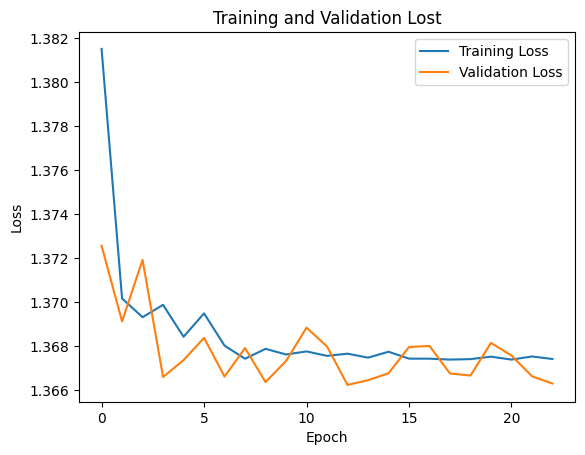

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Lost')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('multi x-ray loss graph.png')
plt.show()
